<a href="https://colab.research.google.com/github/girlwcode/2021DataYouthCampus/blob/master/Week4/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow 실습 : Deep Convolutional Generative Adversarial Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
import time

## 데이터 불러오기 (MNIST)


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


## 모델 정의 및 생성

### Generator

*   noise의 차원은 100을 사용
*   random noise에 우선적으로 Dense layer를 적용
*   2D shape으로 변환 후, Transposed convolution 적용하여 shape을 증가시킴
*   마지막 output layer을 제외하고는 LeakyReLU activation 사용

<img src="https://kjhov195.github.io/post_img/200107/image9.png" width="200">
<img src="https://kjhov195.github.io/post_img/200107/image7.png" width="205">

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size # Dense를 거친 후에 만들어줌

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 정답 이미지도 [-1, 1]로 noarmlization 되어 있으므로(위에서 이미 normalization 해줌), tanh activation 사용 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

학습되지 않은 generator로 이미지 생성

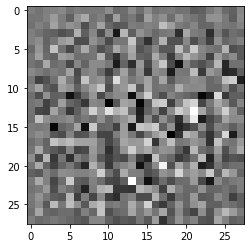

In [4]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])  # (1, 100) shape의 노이즈 샘플링 - 100차원의 벡터 중 한개를 뽑겠다.
generated_image = generator(noise, training=False)  # batch normalization은 training/test 작동이 다름

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

discriminator는 일반적인 image classifier로 정의함

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # real or fake

    return model

*   학습되지 않은 discriminator로 생성된 이미지를 분류해보자
*   discriminator는 real 이미지에 대해서는 (+), fake 이미지에 대해서는 (-)로 예측하도록 학습될 것

In [6]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00161918]], shape=(1, 1), dtype=float32)


## loss function 및 optimizer 정의


In [7]:
'''
discriminator의 아웃풋은 activation하지 않았으므로 from_logits=True
BinaryCrossentropy는 정답은 0 또는 1로 받고
예측값은 from_logits=True인 경우 [-inf, inf], from_logits=False인 경우, [0, 1]
으로 받게 되어 있음
'''
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss


*   real 이미지에 대한 정답은 1
*   생성 이미지에 대한 정답은 0

In [8]:
def discriminator_loss(real_output, fake_output):
    # output의 shape: (# of batch, 1)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
*   generator도 discriminator의 예측 결과에 대한 BCE loss 활용하여 학습
*   real 이미지에 대한 loss는 상관이 없으므로, 생성 이미지에 대한 term만을 활용
*   discriminator loss에 부호 바꾼 형태가 아니므로, non saturating GAN loss

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

학습 알고리즘에서 generator와 discriminator의 parameter를
각각 따로 업데이트하므로 optimizer도 별도로 선언해야 함

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습 알고리즘 선언


In [14]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16

# 학습이 진행됨에 따라 seed를 이용해 이미지 생성을 해볼 예정
seed = tf.random.normal([num_examples_to_generate, noise_dim])



*   강의자료에서의 학습 알고리즘과는 다르게 더 심플한 학습 알고리즘으로 구성되어 있음
*   같은 mini batch에 대해서 discriminator와 generator를 각각 학습

In [16]:
@tf.function
def train_step(images):
    # random noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # generator, discriminator 각각에 대해 gradient tape도 별도로 생성
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # generator loss를 generator parameter에 대해 미분
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # discriminator loss를 discriminator parameter에 대해 미분
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 한 mini batch에 대해 각각 파라미터 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

전체 학습 과정 (한 epoch 학습 종료마다 이미지 생성하여 학습 결과 확인)

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # 전체 batch에 대해 training step 반복
    for image_batch in dataset:
      train_step(image_batch)

    # 한 epoch 학습 후 seed에 대해 이미지 생성 후 저장
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 epochs 마다 모델 저장
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 학습 종료 후 seed에 대해 이미지 생성 후 저장
  generate_and_save_images(generator,
                           epochs,
                           seed)

이미지 생성 결과를 그림 파일로 저장

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # generator에 대해서 seed의 이미지 생성
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 모델 학습


*   GAN 학습은 두 모델을 동시에 학습하기 때문에 잘 학습되지 않을 수 있음
*   한 모델의 성능이 다른 모델보다 압도적으로 잘하면 학습이 실패할 수 있음
*   두 모델이 균형을 이루며 비슷한 속도로 향상되어야 함

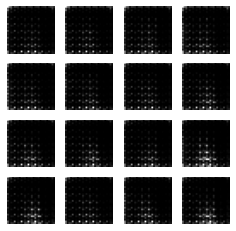

Time for epoch 1 is 15.074390172958374 sec


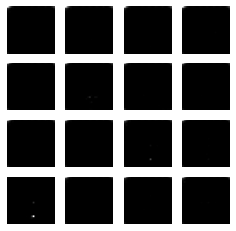

Time for epoch 2 is 12.990410327911377 sec


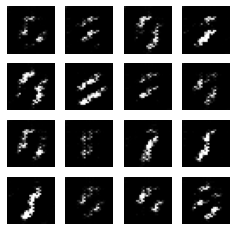

Time for epoch 3 is 12.873162508010864 sec


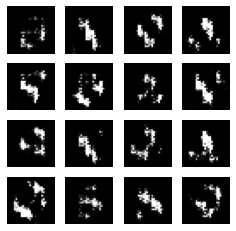

Time for epoch 4 is 12.956421375274658 sec


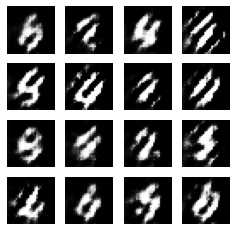

Time for epoch 5 is 13.155302286148071 sec


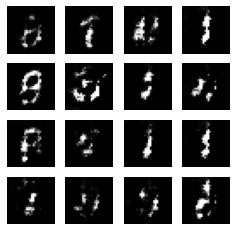

Time for epoch 6 is 13.130234479904175 sec


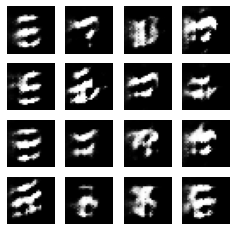

Time for epoch 7 is 13.349241733551025 sec


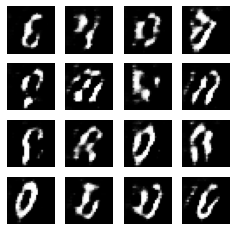

Time for epoch 8 is 13.289127111434937 sec


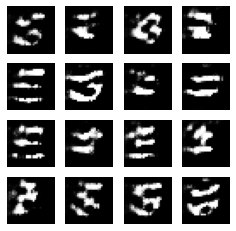

Time for epoch 9 is 13.297654867172241 sec


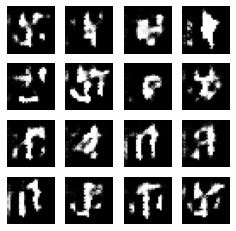

Time for epoch 10 is 13.5300133228302 sec


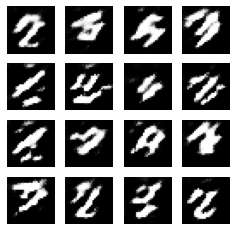

Time for epoch 11 is 13.566494464874268 sec


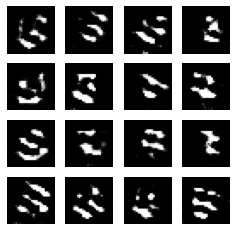

Time for epoch 12 is 13.838738441467285 sec


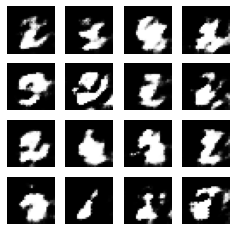

Time for epoch 13 is 14.149675846099854 sec


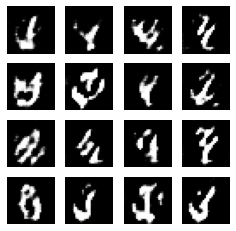

Time for epoch 14 is 13.849754571914673 sec


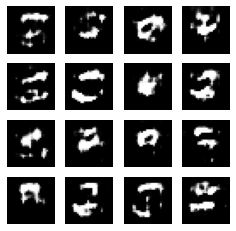

Time for epoch 15 is 13.784771919250488 sec


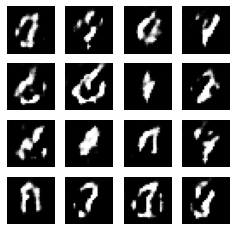

Time for epoch 16 is 13.75907564163208 sec


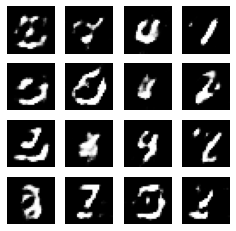

Time for epoch 17 is 13.652265071868896 sec


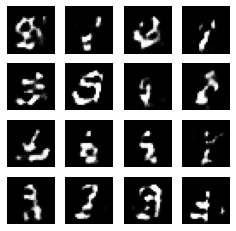

Time for epoch 18 is 13.709871053695679 sec


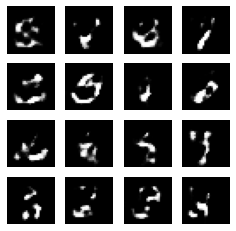

Time for epoch 19 is 13.96179485321045 sec


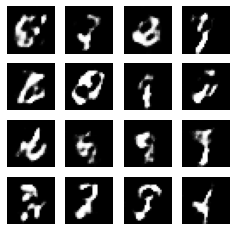

Time for epoch 20 is 13.796729326248169 sec


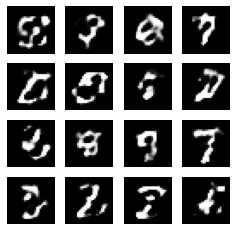

Time for epoch 21 is 13.77061653137207 sec


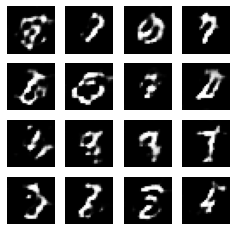

Time for epoch 22 is 13.906759262084961 sec


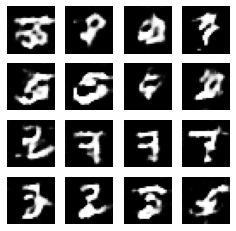

Time for epoch 23 is 13.740903377532959 sec


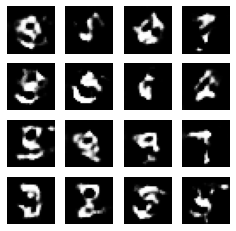

Time for epoch 24 is 13.730534076690674 sec


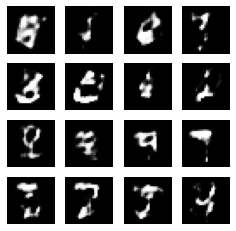

Time for epoch 25 is 13.876840829849243 sec


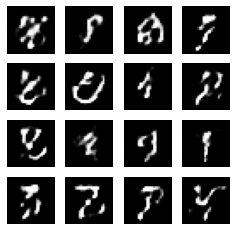

Time for epoch 26 is 13.723515748977661 sec


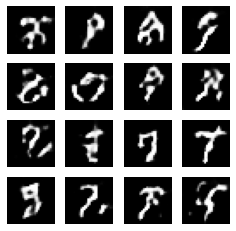

Time for epoch 27 is 13.729797840118408 sec


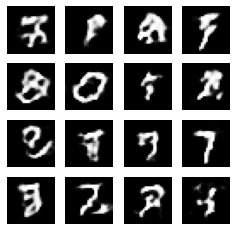

Time for epoch 28 is 13.903016328811646 sec


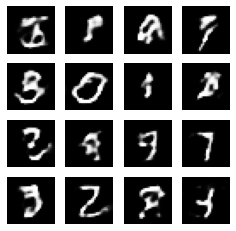

Time for epoch 29 is 13.782516956329346 sec


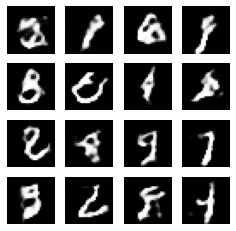

Time for epoch 30 is 13.826348781585693 sec


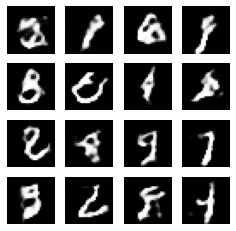

In [19]:
train(train_dataset, EPOCHS)